<a href="https://colab.research.google.com/github/plaban1981/Agents/blob/main/Create_a_multi_modela_agnt_using_CrewAI_Groq_Replicate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Install Required libraries

In [1]:
!pip install -qU langchain langchain_community tavily-python langchain-groq groq replicate


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install -qU crewai crewai[tools]


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Setup API Keys

In [5]:
!pip install  google.colab

ERROR: Could not find a version that satisfies the requirement google.colab (from versions: none)
ERROR: No matching distribution found for google.colab

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:


from google.colab import userdata
userdata.set('OPENAI_API_KEY', 'your-openai-api-key')
userdata.set('REPLICATE_API_TOKEN', 'your-replicate-api-token')
userdata.set('TAVILY_API_KEY', 'your-tavily-api-key')
userdata.set('GROQ_API_KEY', 'your-groq-api-key')

## Create Custom Tools

In [4]:
## Tool for webserach
from crewai_tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults
#@tool("websearch tool")
def web_search_tool(question: str) -> str:
    """This tool is useful when we want web search for current events."""
    # Function logic here
    # Step 1: Instantiate the Tavily client with your API key
    websearch = TavilySearchResults()
    # Step 2: Perform a search query
    response = websearch.invoke({"query":question})
    return response

In [5]:
## Tool for text to speech
import replicate
#@tool("text to speech tool")
#
def text2speech(text:str) -> str:
    """This tool is useful when we want to convert text to speech."""
    # Function logic here
    output = replicate.run(
    "cjwbw/seamless_communication:668a4fec05a887143e5fe8d45df25ec4c794dd43169b9a11562309b2d45873b0",
    input={
        "task_name": "T2ST (Text to Speech translation)",
        "input_text": text,
        "input_text_language": "English",
        "max_input_audio_length": 60,
        "target_language_text_only": "English",
        "target_language_with_speech": "English"
    }
    )
    return output["audio_output"]

In [6]:
#@tool("text to image tool")
def text2image(text:str) -> str:
    """This tool is useful when we want to generate images from textual descriptions."""
    # Function logic here
    output = replicate.run(
    "xlabs-ai/flux-dev-controlnet:f2c31c31d81278a91b2447a304dae654c64a5d5a70340fba811bb1cbd41019a2",
    input={
        "steps": 28,
        "prompt": text,
        "lora_url": "",
        "control_type": "depth",
        "control_image": "https://replicate.delivery/pbxt/LUSNInCegT0XwStCCJjXOojSBhPjpk2Pzj5VNjksiP9cER8A/ComfyUI_02172_.png",
        "lora_strength": 1,
        "output_format": "webp",
        "guidance_scale": 2.5,
        "output_quality": 100,
        "negative_prompt": "low quality, ugly, distorted, artefacts",
        "control_strength": 0.45,
        "depth_preprocessor": "DepthAnything",
        "soft_edge_preprocessor": "HED",
        "image_to_image_strength": 0,
        "return_preprocessed_image": False
        }
    )
    print(output)
    return output[0]

#### Text to Image

In [7]:
from crewai_tools import DallETool
# generate images from textual descriptions
dalle_tool = DallETool(model="dall-e-3",
                       size="1024x1024",
                       quality="standard",
                       n=1)

In [ ]:
text2speech("I am Plaban Nayak?")

'https://replicate.delivery/pbxt/1klGVCNKxabOH5mpgdZMqjJ4uXUL8T8hmDV92XREs4ELYeqJA/out.wav'

In [8]:
## text to image
def image2text(image_url:str,prompt:str) -> str:
  """This tool is useful when we want to generate textual descriptions from images."""
  # Function
  output = replicate.run(
    "yorickvp/llava-13b:80537f9eead1a5bfa72d5ac6ea6414379be41d4d4f6679fd776e9535d1eb58bb",
    input={
        "image": image_url,
        "top_p": 1,
        "prompt": prompt,
        "max_tokens": 1024,
        "temperature": 0.2
    }
  )
  return "".join(output)

In [90]:
## Router Tool
@tool("router tool")
def router_tool(question:str) -> str:
  """Router Function"""
  prompt = f"""Based on the Question provide below determine the following:
1. Is the question directed at generating image ?
2. Is the question directed at describing the image ?
3. Is the question directed at converting text to speech?.
4. Is the question a generic one and needs to be answered searching the web?
Question: {question}

RESPONSE INSTRUCTIONS:
- Answer either 1 or 2 or 3 or 4.
- Answer should strictly be a string.
- Do not provide any preamble or explanations except for 1 or 2 or 3 or 4.

OUTPUT FORMAT:
1
"""
  response = llm.invoke(prompt).content
  if response == "1":
    return 'text2image'
  elif response == "3":
    return 'text2speech'
  elif response == "4":
    return 'web_search'
  else:
    return 'image2text'

In [91]:
@tool("retriver tool")
def retriver_tool(router_response:str,question:str,image_url:str) -> str:
  """Retriver Function"""
  if router_response == 'text2image':
    return text2image(question)
  elif router_response == 'text2speech':
    return text2speech(question)
  elif router_response == 'image2text':
    return image2text(image_url,question)
  else:
    return web_search_tool(question)

## Setup the llm

In [11]:
from langchain_groq import ChatGroq
llm = ChatGroq(model_name="llama-3.1-70b-versatile",
    temperature=0.1,
    max_tokens=1000,
)

In [ ]:
llm.invoke("What is the importance of large language models?")

AIMessage(content="Large language models are a crucial development in natural language processing (NLP) and artificial intelligence (AI). Their importance can be seen in several areas:\n\n1. **Improved Language Understanding**: Large language models can process and understand vast amounts of text data, enabling them to learn complex patterns and relationships in language. This leads to better language comprehension and generation capabilities.\n2. **Enhanced Text Generation**: These models can generate coherent and context-specific text, making them useful for applications like chatbots, language translation, and content creation.\n3. **Automation of Repetitive Tasks**: Large language models can automate tasks like data entry, text summarization, and sentiment analysis, freeing up human resources for more strategic and creative work.\n4. **Personalized Customer Experience**: By analyzing customer interactions and generating personalized responses, large language models can help busines

## Define Agents

In [92]:
from crewai import Agent
Router_Agent = Agent(
  role='Router',
  goal='Route user question to a text to image or text to speech or web search',
  backstory=(
    "You are an expert at routing a user question to a text to image or text to speech or web search."
    "Use the text to image to generate images from textual descriptions."
    "Use the text to speech to convert text to speech."
    "Use the image to text to generate text describing the image based on the textual description."
    "Use the web search to search for current events."
    "You do not need to be stringent with the keywords in the question related to these topics. Otherwise, use web-search."
  ),
  verbose=True,
  allow_delegation=False,
  llm=llm,
  tools=[router_tool],
)

In [93]:
##Retriever Agent
Retriever_Agent = Agent(
role="Retriever",
goal="Use the information retrieved from the Router to answer the question and image url provided.",
backstory=(
    "You are an assistant for directing tasks to respective agents based on the response from the Router."
    "Use the information from the Router to perform the respective task."
    "Do not provide any other explanation"
),
verbose=True,
allow_delegation=False,
llm=llm,
tools=[retriver_tool],
)

In [46]:
Image2Text_Agent = Agent(
    role="Image2Text",
    goal="Generate images from textual descriptions",
    backstory=(
        "You are an expert at generating images from textual descriptions."
        "Use the text to image to generate images from textual descriptions."
    ),
    tools=[text2image],
    verbose=True,
    allow_delegation=False,
    llm=llm,
)

ValidationError: 1 validation error for Agent
  Value error, 1 validation error for CrewAgentExecutor
tools -> 0
  value is not a valid dict (type=type_error.dict) [type=value_error, input_value={'role': 'Image2Text', 'g...***'), max_tokens=1000)}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.8/v/value_error

In [ ]:
speech_Agent = Agent(
    role="Text2Speech",
    goal="Convert text to speech",
    backstory=(
        "You are an expert at converting English Text to English Speech."
        "Use the text to speech to convert text to speech."
    ),
    tools=[text2speech],
    verbose=True,
    allow_delegation=False,
    llm=llm,
)

In [ ]:
websearch_agent = Agent(
    role="WebSearch",
    goal="Search for current events from web",
    backstory=(
        "You are an expert at searching for current events from the web."
        "Use the web search to search for current events."
    ),
    tools=[web_search_tool],
    verbose=True,
    allow_delegation=False,
    llm=llm,
)

### Define Tasks

In [94]:
from crewai import Task
router_task = Task(
    description=("Analyse the keywords in the question {question}"
    "If the question {question} instructs to describe a image then use the image url {image_url} to generate a detailed and high quality images covering all the nuances secribed in the textual descriptions provided in the question {question}."
    "Based on the keywords decide whether it is eligible for a text to image or text to speech or web search."
    "Return a single word 'text2image' if it is eligible for generating images from textual description."
    "Return a single word 'text2speech' if it is eligible for converting text to speech."
    "Return a single word 'image2text' if it is eligible for describing the image based on the question {question} and iamge url{image_url}."
    "Return a single word 'web_search' if it is eligible for web search."
    "Do not provide any other premable or explaination."
    ),
    expected_output=("Give a choice 'web_search' or 'text2image' or 'text2speech'  or 'image2text' based on the question {question} and image url {image_url}"
    "Do not provide any preamble or explanations except for 'text2image' or 'text2speech' or 'web_search' or 'image2text'."),
    agent=Router_Agent,
)

In [95]:
retriever_task = Task(
    description=("Based on the response from the 'router_task' generate response for the question {question} with the help of the respective tool."
    "Use the web_serach_tool to retrieve information from the web in case the router task output is 'web_search'."
    "Use the text2speech tool to convert the test to speech in english in case the router task output is 'text2speech'."
    "Use the text2image tool to convert the test to speech in english in case the router task output is 'text2image'."
    "Use the image2text tool to describe the image provide in the image url in case the router task output is 'image2text'."
    ),
    expected_output=("You should analyse the output of the 'router_task'"
    "If the response is 'web_search' then use the web_search_tool to retrieve information from the web."
    "If the response is 'text2image' then use the text2image tool to generate a detailed and high quality images covering all the nuances secribed in the textual descriptions provided in the question {question}."
    "If the response is 'text2speech' then use the text2speech tool to convert the text provided in the question {question} to speech"
    "If the response is 'image2text' then use the 'image2text' tool to describe the image based on the question {question} and {image_url}."
    ),
    agent=Retriever_Agent,
    context=[router_task],
)

## Build the Crew

In [96]:
from crewai import Crew,Process
crew = Crew(
    agents=[Router_Agent,Retriever_Agent],
    tasks=[router_task,retriever_task],
    verbose=True,
)



In [ ]:
inputs_image ={"question":"Generate an image based upon this text: A Yellow Lab pupy running free with wild blue flowers around and a partially covered moutain in the background"}

In [ ]:
inputs ={"question":"Generate an image based upon this text: a cyberpunk with natural greys and whites and browns"}

In [ ]:
inputs ={"question":"Generate an image based upon this text: a photo of a cyberpunk 0_1 woman, perfect eyes, bokeh, 50mm photo, neon pink visor"}

In [ ]:
inputs = {"question":"Where is the Effiel Tower Located?"}

In [24]:
inputs ={"question":"Provide a detailed description.","image_url":"https://images.unsplash.com/photo-1470770903676-69b98201ea1c?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1740&q=80.jpg"}

## Kick off the crew

#### agent to desribe the image based on the question provided

In [33]:
result = crew.kickoff(inputs=inputs)

 [2024-08-25 03:29:53][DEBUG]: == Working Agent: Router
 [2024-08-25 03:29:53][INFO]: == Starting Task: Analyse the keywords in the question Provide a detailed description.If the question Provide a detailed description. instructs to describe a image then use the image url https://images.unsplash.com/photo-1470770903676-69b98201ea1c?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1740&q=80.jpg to generate a detailed and high quality images covering all the nuances secribed in the textual descriptions provided in the question Provide a detailed description..Based on the keywords decide whether it is eligible for a text to image or text to speech or web search.Return a single word 'text2image' if it is eligible for generating images from textual description.Return a single word 'text2speech' if it is eligible for converting text to speech.Return a single word 'image2text' if it is eligible for describing the image based on the question Provide a det

In [34]:
result.raw

"The image provided is a scenic view of a mountain range with a serene lake in the foreground. The mountains are covered in lush green forests, and the lake is reflecting the beauty of the surrounding landscape. The image is a perfect representation of nature's splendor and tranquility."

#### Display the image for which the Agent has provided the description

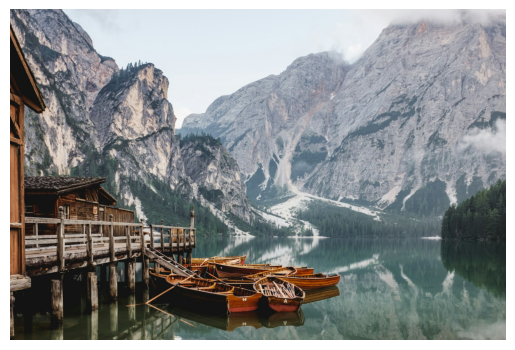

In [35]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

# URL of the image
image_url = "https://images.unsplash.com/photo-1470770903676-69b98201ea1c?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1740&q=80.jpg"

# Fetch the image
response = requests.get(image_url)

# Check if the request was successful
if response.status_code == 200:
    # Open the image using PIL
    img = Image.open(BytesIO(response.content))

    # Display the image using matplotlib
    plt.imshow(img)
    plt.axis('off')  # Hide the axis
    plt.show()
else:
    print("Failed to retrieve image. Status code:", response.status_code)

## Image Generation

In [103]:
inputs ={"question":"Generate an image based upon this text: a close up portfolio photo of a beautiful Indian Model woman, perfect eyes, bright studio lights, bokeh, 50mm photo, neon pink visor","image_url":" "}

In [104]:
result = crew.kickoff(inputs=inputs)

 [2024-08-25 04:14:22][DEBUG]: == Working Agent: Router
 [2024-08-25 04:14:22][INFO]: == Starting Task: Analyse the keywords in the question Generate an image based upon this text: a close up portfolio photo of a beautiful Indian Model woman, perfect eyes, bright studio lights, bokeh, 50mm photo, neon pink visorIf the question Generate an image based upon this text: a close up portfolio photo of a beautiful Indian Model woman, perfect eyes, bright studio lights, bokeh, 50mm photo, neon pink visor instructs to describe a image then use the image url   to generate a detailed and high quality images covering all the nuances secribed in the textual descriptions provided in the question Generate an image based upon this text: a close up portfolio photo of a beautiful Indian Model woman, perfect eyes, bright studio lights, bokeh, 50mm photo, neon pink visor.Based on the keywords decide whether it is eligible for a text to image or text to speech or web search.Return a single word 'text2image

In [105]:
result.raw

'https://replicate.delivery/yhqm/XjBShO4PSexSSaThOCnZoDl4rYeq1pNAZNaKIuvi3mvFHGWTA/R8_FLUX_XLABS_00001_.webp'

## Display Image

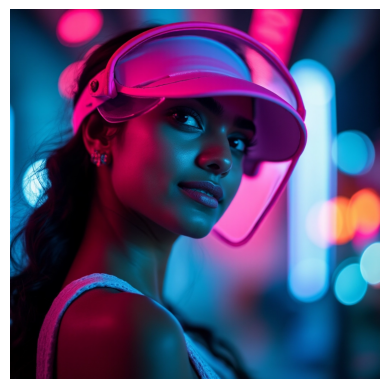

In [106]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

# URL of the image
image_url = result.raw

# Fetch the image
response = requests.get(image_url)

# Check if the request was successful
if response.status_code == 200:
    # Open the image using PIL
    img = Image.open(BytesIO(response.content))

    # Display the image using matplotlib
    plt.imshow(img)
    plt.axis('off')  # Hide the axis
    plt.show()
else:
    print("Failed to retrieve image. Status code:", response.status_code)

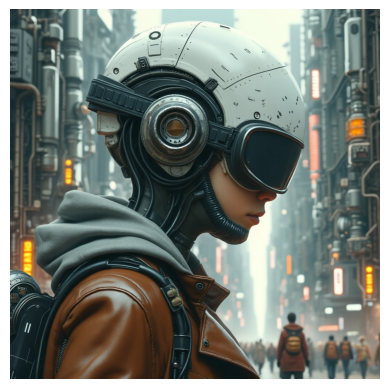

In [ ]:
# URL of the image
image_url = "https://replicate.delivery/yhqm/v8TZfCGKQq0PeU65G2pLlqKxOcVq6vaZCfj3wy9kJyysT2rmA/R8_FLUX_XLABS_00001_.webp"

# Fetch the image
response = requests.get(image_url)

# Check if the request was successful
if response.status_code == 200:
    # Open the image using PIL
    img = Image.open(BytesIO(response.content))

    # Display the image using matplotlib
    plt.imshow(img)
    plt.axis('off')  # Hide the axis
    plt.show()
else:
    print("Failed to retrieve image. Status code:", response.status_code)

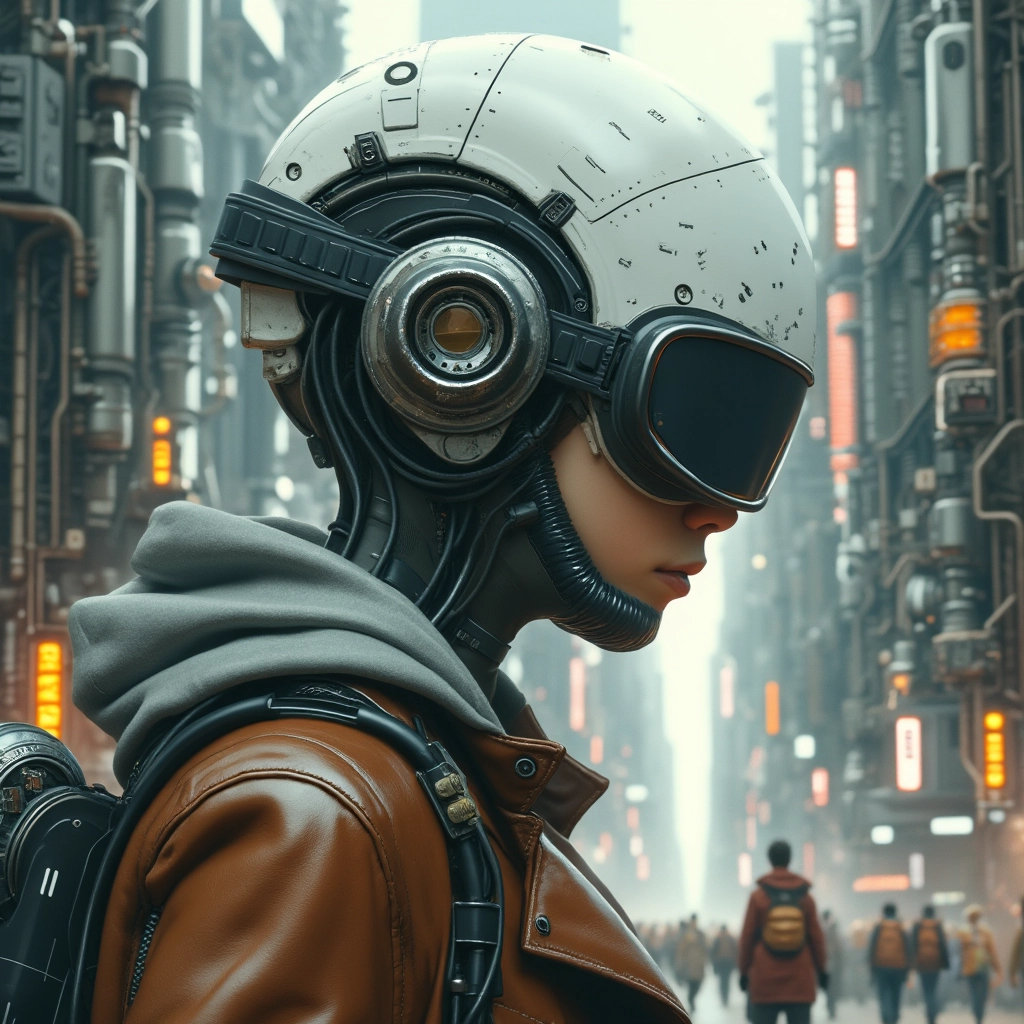

## Speech Generation

In [99]:
inputs_speech ={"question":"Generate a speech for this text: The image features a small white dog running down a dirt path.The dog is happily smiling as it runs and the path is lined with beautiful blue flowers.","image_url":" "}

In [100]:
result = crew.kickoff(inputs=inputs_speech)

 [2024-08-25 04:07:05][DEBUG]: == Working Agent: Router
 [2024-08-25 04:07:05][INFO]: == Starting Task: Analyse the keywords in the question Generate a speech for this text: The image features a small white dog running down a dirt path.The dog is happily smiling as it runs and the path is lined with beautiful blue flowers.If the question Generate a speech for this text: The image features a small white dog running down a dirt path.The dog is happily smiling as it runs and the path is lined with beautiful blue flowers. instructs to describe a image then use the image url   to generate a detailed and high quality images covering all the nuances secribed in the textual descriptions provided in the question Generate a speech for this text: The image features a small white dog running down a dirt path.The dog is happily smiling as it runs and the path is lined with beautiful blue flowers..Based on the keywords decide whether it is eligible for a text to image or text to speech or web search

In [101]:
result.raw

'https://replicate.delivery/pbxt/fIc6LQ7aves7TECSIMcqOfSgtMwjebRk0KFClnQjT2HtDYYNB/out.wav'

## Play the Audio

In [102]:
from IPython.display import Audio

# URL of the audio file
audio_url = result.raw

# Play the audio file
Audio(audio_url, autoplay=True)

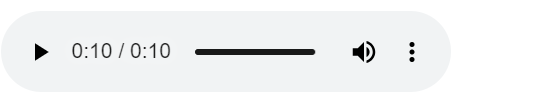

#### Agent to present results from websearch

In [97]:
inputs = {"question":"tourist destinations in India.","image_url":" "}
result = crew.kickoff(inputs=inputs)

 [2024-08-25 04:06:30][DEBUG]: == Working Agent: Router
 [2024-08-25 04:06:30][INFO]: == Starting Task: Analyse the keywords in the question tourist destinations in India.If the question tourist destinations in India. instructs to describe a image then use the image url   to generate a detailed and high quality images covering all the nuances secribed in the textual descriptions provided in the question tourist destinations in India..Based on the keywords decide whether it is eligible for a text to image or text to speech or web search.Return a single word 'text2image' if it is eligible for generating images from textual description.Return a single word 'text2speech' if it is eligible for converting text to speech.Return a single word 'image2text' if it is eligible for describing the image based on the question tourist destinations in India. and iamge url .Return a single word 'web_search' if it is eligible for web search.Do not provide any other premable or explaination.


> Entering 

In [98]:
result.raw

"The top tourist destinations in India include:\n\n1. The Taj Mahal in Agra, a stunning white marble monument and one of the Seven Wonders of the World.\n2. The Ajanta and Ellora Caves in Maharashtra, ancient Buddhist and Jain cave monuments.\n3. The Golden Temple in Amritsar, a revered Sikh temple made of white marble and gold.\n4. The city of Jaisalmer in Rajasthan, known for its stunning architecture and desert landscapes.\n5. The hill station of Shimla in Himachal Pradesh, a popular destination for trekking and relaxation.\n6. The city of Rishikesh in Uttarakhand, known for its spiritual significance and adventure activities.\n7. The state of Goa, known for its beautiful beaches, riverine islands, and dense forests.\n8. The city of Jodhpur in Rajasthan, known for its blue-painted buildings and historic Mehrangarh Fort.\n9. The city of Udaipur in Rajasthan, known for its stunning lakeside palaces and scenic beauty.\n10. The state of Ladakh, known for its breathtaking landscapes, Bud